# Constants

In [1]:
IALAB_USER = 'jiossandon'

In [2]:
from platform import python_version

print(python_version())

3.6.9


# Imports

In [3]:
import os
import os.path as osp
import json
import sys

In [4]:
matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'

In [5]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [6]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

In [7]:
with open(f"/home/{IALAB_USER}/storage/speaker_follower_with_objects/tasks/R2R/data/train_vocab.txt", "r") as file:
    train_vocab = [line.rstrip() for line in file]

# Simulator

In [124]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading

    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [125]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

## Initialize data for after processing

In [126]:
from collections import defaultdict

viewpoints_information = defaultdict(dict)

# Visualization

In [193]:
LABEL_MAPPING = {
    'a': 'bathroom',
    'b': 'bedroom',
    'c': 'closet',
    'd': 'dining room',
    'e': 'entryway',
    'f': 'family room',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundry',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'conference room',
    'n': 'lounge',
    'o': 'office',
    'p': 'terrace',
    'r': 'game room',
    's': 'stairs',
    't': 'toilet',
    'u': 'utility room',
    'v': 'tv',
    'w': 'gym',
    'x': 'outdoor area',
    'y': 'balcony',
    'z': 'other room',
    'B': 'bar',
    'C': 'classroom',
    'D': 'dining booth',
    'S': 'spa',
    'Z': 'junk',
    '-': 'other room'
}

def get_viewpoint_region_name(metadata, viewpoint):
    values = metadata.get_region(viewpoint).label.values
    if not values.size > 0:
        return 'other room'
    label_keyword = values[0]
    return LABEL_MAPPING[label_keyword]

In [194]:
import math
import re

def get_distance_between(obj, viewpoint_heading, viewpoint_distance):
    pi = np.pi
    
    angle_between = abs(viewpoint_heading - obj['heading'])
    
    distance_between = math.sqrt(obj['distance']**2 + viewpoint_distance**2 - 2* obj['distance']* viewpoint_distance * math.cos(angle_between))
    
    return distance_between

def get_closer_object(objects, viewpoint_heading, viewpoint_distance, used_objects):   
    pi = np.pi
    sort_func = lambda obj: get_distance_between(obj, viewpoint_heading, viewpoint_distance)
    
    sorted_objs = sorted(objects, key=sort_func)
    
    for obj in sorted_objs:
        angle_between = viewpoint_heading - obj['heading']
        if not -pi/2 <= angle_between <= pi/2:
            continue
            
        if abs(obj['elevation']) > 0.6:
            continue
        
        obj_components = re.split('#|/', obj['name'])
        obj_components = [x for x in obj_components if x]
        obj['name'] = ' '.join(obj_components)
        
        object_in_vocab = all([x in train_vocab for x in obj_components])
                        
        if obj['distance'] < viewpoint_distance and object_in_vocab and obj['name'] not in used_objects:
            return obj
        
def get_final_closer_object(objects, used_objects, current_heading):
    sort_func = lambda obj: obj['distance']
    
    sorted_objs = sorted(objects, key=sort_func)
    for obj in sorted_objs:
        obj_components = re.split('#|/', obj['name'])
        obj_components = [x for x in obj_components if x]
        obj['name'] = ' '.join(obj_components)
        
        object_in_vocab = all([x in train_vocab for x in obj_components])
    
        heading = obj['heading']
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi
        
        if object_in_vocab and get_reference(heading) != 'behind' and obj['distance'] < 2:
            obj['orientation'] = get_reference(heading)
            return obj

In [195]:
import random

def get_reference(heading):
    pi = np.pi
    if pi/2 <= heading < (pi - 1/2):
        return 'left'
    elif (pi - 1/2) <= heading <= (pi + 1/2):
        return 'front'
    elif (pi + 1/2) < heading < 3 * pi/2:
        return 'right'
    else:
        return 'behind'
    
def get_hard_turn(heading):
    pi = np.pi
    RANGE_GAP = 0.4
    if pi/2 - RANGE_GAP <= heading <= pi/2 + RANGE_GAP:
        return 'left'
    elif 3 * pi/2 - RANGE_GAP <= heading <= 3 * pi/2 + RANGE_GAP:
        return 'right'
    elif heading <= RANGE_GAP  or heading >=  2 * pi - RANGE_GAP:
        return 'around'
    
    return None

def get_object_from_viewpoint_orientation(obj, next_viewpoint):
    if obj['heading'] > next_viewpoint['heading']:
        return 'right'
    return 'left'
        
def get_same_room_instruction(next_viewpoint, hard_turn):
    RANGE_GAP = 0.4
    pi = np.pi
    
    if hard_turn:
        return 'walk forward'
    heading = next_viewpoint['heading']
    
    if pi/2 + RANGE_GAP < heading < pi - RANGE_GAP * 3:
        return 'turn around and walk forward'
    elif pi + 3 * RANGE_GAP < heading < 3 * pi/2 - RANGE_GAP:
        return 'turn around and walk forward'
    elif RANGE_GAP < heading < pi/2 - RANGE_GAP:
        return 'turn around and walk forward'
    elif 3 * pi/2 + RANGE_GAP < heading < 2 * pi - RANGE_GAP :
        return 'turn around and walk forward'
    else:
        return 'walk forward'
    

In [196]:
def opposite_orientation(orientation):
    if (orientation == 'left'):
        return 'right'
    return 'left'

FORBIDDEN_WORDS = [
  'doorframe', 'light', 'floor', 'ceiling', 'remove', 'otherroom',
  'roof', 'unknown', 'wall', 'door', 'rug', 'frame', 'column', 'window', 
  'column', 'celing', 'door', 'picture', 'delete', 'stairs', 'stair', 'handrail', 'object'
]
TURN_EXPRESSIONS = [
    lambda orientation: f"turn {orientation}", 
    lambda orientation: f"take a {orientation}", 
    lambda orientation: f"make a {orientation}", 
]
MOVE_FROM_REGION_TO_OTHER =  [
    lambda current_region, next_region: f"exit the {current_region} to the {next_region}", 
]
MOVE_TO_OBJECT_REFERENCE = [
    lambda orientation, object_name: f"go straight with the {object_name} on your {orientation}", 
    lambda orientation, object_name: f"walk straight down the {opposite_orientation(orientation)} side of the {object_name}", 
]

MOVE_TO_OTHER_ROOM_WITH_OBJECT = [
    lambda current_region, next_region, object_orientation, object_name: f"exit the {current_region} to the {next_region} walking by the {opposite_orientation(object_orientation)} side of the {object_name}",
    lambda current_region, next_region, object_orientation, object_name: f"go out of {current_region} into the {next_region} walking with the {object_name} on your {object_orientation}"
]

MOVE_ON_THE_SAME_ROOM = [
    lambda orientation: f"turn a little to the {orientation} and walk forward",
    lambda orientation: f"walk straight a little to the {orientation}",
    lambda orientation: f"walk straight slightly to the {orientation}",
    lambda orientation: f"turn slightly to the {orientation} and walk forward"
]

MOVE_ON_THE_SAME_ROOM_BACK = [
    lambda orientation: f"turn around and walk forward a little to the {orientation}",
    lambda orientation: f"turn around and go straight slightly to the {orientation}",
    lambda orientation: f"turn around and walk forward slightly to the {orientation}",
    lambda orientation: f"turn around and go straight a little to the {orientation}"
]

def final_object(object_name, orientation):
    if orientation == "front":
        return random.choice([
            f"stop in front of the {object_name}",
            f"wait just in front of the {object_name}"
        ])
    elif orientation == "behind":
        return random.choice([
            f"wait with the {object_name} on your back",
            f"stop passing by the {object_name} behind you"
        ])
    else:
        if orientation == 'left':
            opposite_orientation = 'right'
        else:
            opposite_orientation = 'left'
        return random.choice([
            f"wait at the {opposite_orientation} of the {object_name}",
            f"stop on the {opposite_orientation} of the {object_name}"
        ])


WAIT = [
    'wait there',
    'stop',
    ''
]

In [197]:
import random

def get_craft_short_instruction(region_name_of_current_viewpoint, viewpoint_heading, viewpoint_info, next_viewpoint, used_objects=[]):
    instrs = []
    best_object = None
        
    if next_viewpoint:
        hard_turn = get_hard_turn(next_viewpoint['heading'])
        if hard_turn:
            if hard_turn == 'around':
                instrs.append('turn around')
            else:
                instrs.append(random.choice(TURN_EXPRESSIONS)(hard_turn))
        
        best_object = get_closer_object(viewpoint_info['objects'], next_viewpoint['heading'], next_viewpoint['distance'], used_objects)
        if best_object:
            orientation = get_object_from_viewpoint_orientation(best_object, next_viewpoint)
            
            # If we do not change the environment just append the object
            if region_name_of_current_viewpoint == next_viewpoint['name']:
                object_phrase = random.choice(MOVE_TO_OBJECT_REFERENCE)(orientation, best_object['name'])
                instrs.append(object_phrase)
            else:
                object_phrase_with_room_change = random.choice(MOVE_TO_OTHER_ROOM_WITH_OBJECT)(region_name_of_current_viewpoint, next_viewpoint['name'], orientation, best_object['name'])
                instrs.append(object_phrase_with_room_change)
        else:
            # If we do not change the environment use instructions on the same environment
            if region_name_of_current_viewpoint == next_viewpoint['name']:
                instruction = get_same_room_instruction(next_viewpoint, hard_turn)
                instrs.append(instruction)
            else:
                phrase_with_room_change = random.choice(MOVE_FROM_REGION_TO_OTHER)(region_name_of_current_viewpoint, next_viewpoint['name'])
                instrs.append(phrase_with_room_change)
    else:
        best_object = get_final_closer_object(viewpoint_info['objects'], used_objects, viewpoint_heading)
        if best_object:
            instrs.append(final_object(best_object['name'], best_object['orientation']))
        else:
            instrs.append(random.choice(WAIT))
        
    cleaned_instrs = list(filter(lambda x: len(x) >= 1, instrs))
    return ", ".join(cleaned_instrs), best_object



In [198]:
import matplotlib.patches as patches

IMG_HEIGHT = 1440
IMG_WIDTH = 2880

def get_info(scan, viewpoint, viewpoint_heading, next_viewpoint, metadata, viewpoints_information, used_objects, visualize=True):
    objects = metadata.angle_relative_viewpoint_objects(viewpoint)
            
    # Add to post processing data
    viewpoints_information[viewpoint]['objects'] = []
    viewpoints_information[viewpoint]['viewpoints'] = []

    connectivity_path = f'/home/{IALAB_USER}/repos/360-visualization/connectivity/{scan}_connectivity.json'
    reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path)
    
    if visualize:
        images = []
        for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
            im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
            images.append(im)

        fig, ax = plt.subplots(1,1, figsize=(18,9))

        img = np.concatenate(images[::-1], axis=0)

        ax.imshow(img)
        plt.xticks(np.linspace(0, IMG_WIDTH - 1, 5), [-180, -90, 0, 90, 180])
        plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
        plt.yticks(np.linspace(0, IMG_HEIGHT - 1, 5), [-180, -90, 0, 90, 180])
    
    next_heading = viewpoint_heading
    x0, y0 = viewpoint_heading, 0
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name
        
        if any(word in category for word in FORBIDDEN_WORDS):
            continue

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
        
        CONST = 300 * 1/obj.distance * 3
        
        # Add to post processing data
        viewpoints_information[viewpoint]['objects'].append(
            {
                'name': category,
                'heading': first_coord / IMG_WIDTH * 2 * np.pi,
                'elevation': elevation,
                'distance': obj.distance,
                'radius': (obj.r0, obj.r1, obj.r2),
                'area': float(obj.r1) * CONST * float(obj.r0) * CONST
            }
        )
        
        if visualize:
            first_pos = first_coord - float(obj.r1) * CONST / 2
            second_pos = second_coord - float(obj.r0) * CONST / 2
            rect = patches.Rectangle((first_pos, second_pos), float(obj.r1) * CONST, float(obj.r0) * CONST, linewidth=1, edgecolor='r', facecolor='none')
            #ax.add_patch(rect)
            ax.text(first_coord, second_coord, f'{category}', color='white', backgroundcolor='black')

    
    next_viewpoint_data = None
    for reachable_viewpoint in reachable_viewpoints.itertuples():
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)
        
        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
        
        region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)
        
        viewpoint_info_to_add = {
                'name': region_name_of_viewpoint,
                'heading': first_coord / IMG_WIDTH * 2 * np.pi,
                'distance': reachable_viewpoint.distance,
                'elevation': reachable_viewpoint.elevation
        }
        
        if reachable_viewpoint.name == next_viewpoint:
            next_viewpoint_data = viewpoint_info_to_add
            next_heading += heading

            if visualize:
                ax.arrow(first_coord, second_coord + 150, 0, -50, width=20, color='green')
        
        # Add to post processing data
        viewpoints_information[viewpoint]['viewpoints'].append(viewpoint_info_to_add)
        
        if visualize:
            ax.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='black')
            ax.plot(first_coord, second_coord, color='blue', marker='o', 
                     markersize= 15 / reachable_viewpoint.distance, linewidth=1)

    region_name_of_current_viewpoint = get_viewpoint_region_name(metadata, viewpoint)
    new_short_craft_instruction, used_object = get_craft_short_instruction(region_name_of_current_viewpoint, viewpoint_heading, viewpoints_information[viewpoint], next_viewpoint_data, used_objects)

    return new_short_craft_instruction, next_heading, used_object

In [199]:
plt.close('all')

### Define the instruction to overview

In [243]:
instructions_path = f'/home/{IALAB_USER}/storage/objects-auxiliary/paths/R2R_train.json'

# Search by path id first. If it doesnt exist, then search by instruction index.
instruction_index = 40
path_id = 1100

In [244]:
instruction_data = {}
with open(instructions_path, 'r') as f:
    data = json.load(f)
    print(f"The file contain {len(data)} paths. The index must be between 0 and {len(data) - 1}.")
    for elem in data:
        if int(elem['path_id']) == path_id:
            print("Yep, found by path id")
            instruction_data = elem
    if instruction_data == {}:
        instruction_data = data[instruction_index]
    
scan = instruction_data['scan']
viewpoints_sequence = instruction_data['path']
initial_heading = instruction_data['heading']

The file contain 4675 paths. The index must be between 0 and 4674.


### Set the metadata and cell display

In [245]:
metadata = metadata = HouseSegmentationFile.load_mapping(scan)
print("Press 'Shift + O' on Jupyter Notebook for avoid cell collapse")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) # Bigger height of the cell output

Cached file exists, loading.
Press 'Shift + O' on Jupyter Notebook for avoid cell collapse


### Plot viewpoints and save the data

- Walk past the large picture and chair. Walk past the dining room table turn right into the hallway and stop. 

- Go straight and pass the bar with the chair/stools then pass the clear glass table with the white chairs and turn right. Wait in that hallway. 

- With the painting of the mermaid towards your right, head straight. After passing the counter towards your right, turn right and wait. 

- turn left, walk straight down the left side of the painting. walk forward. exit the living room to the dining room. go out of dining room into the entryway walking with the sofa chair on your left. wait there


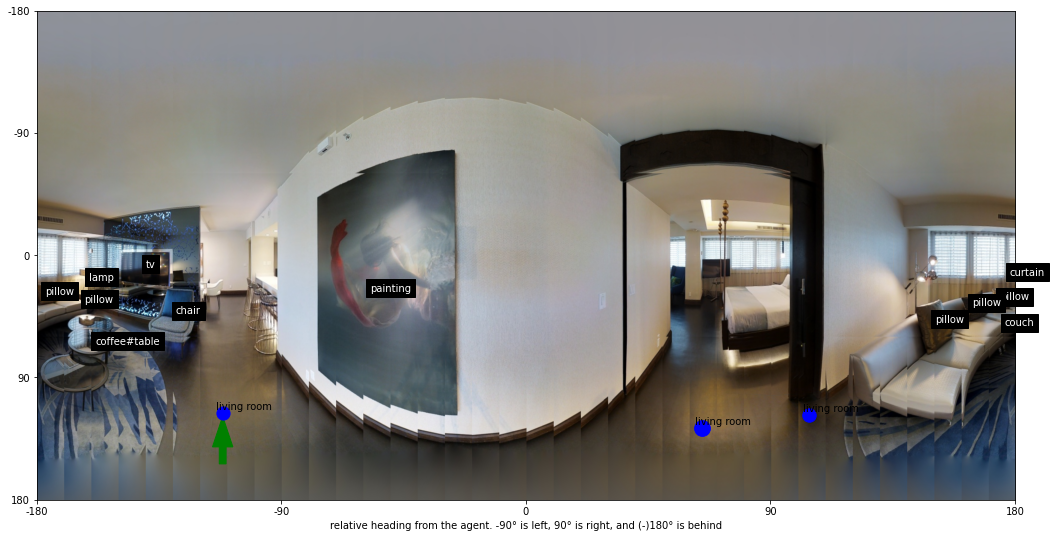

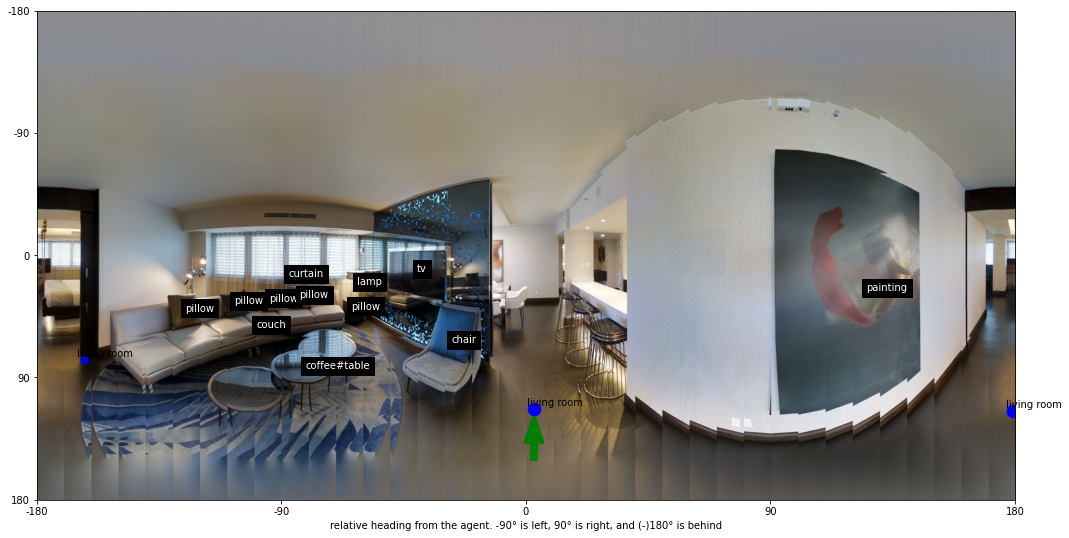

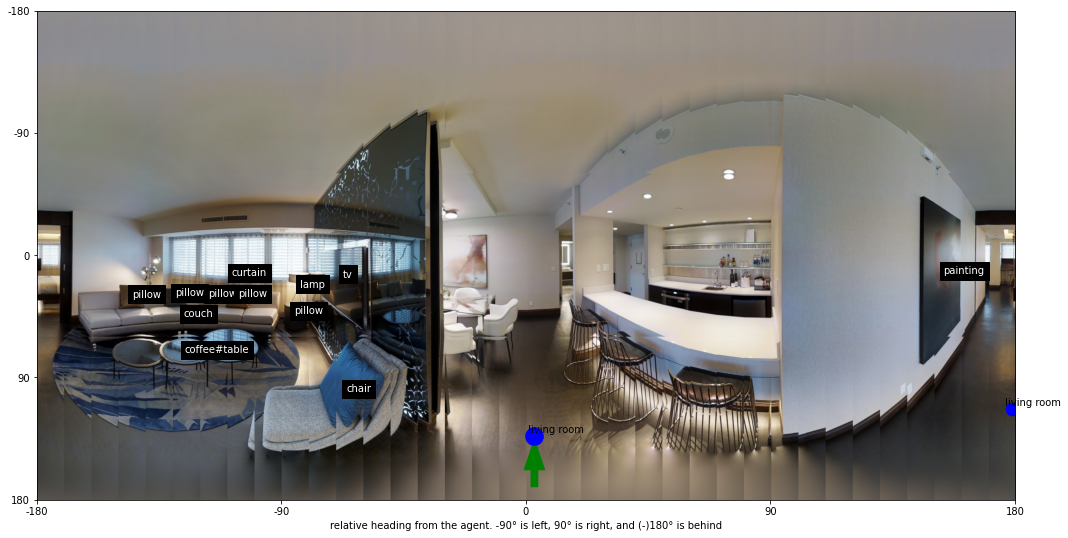

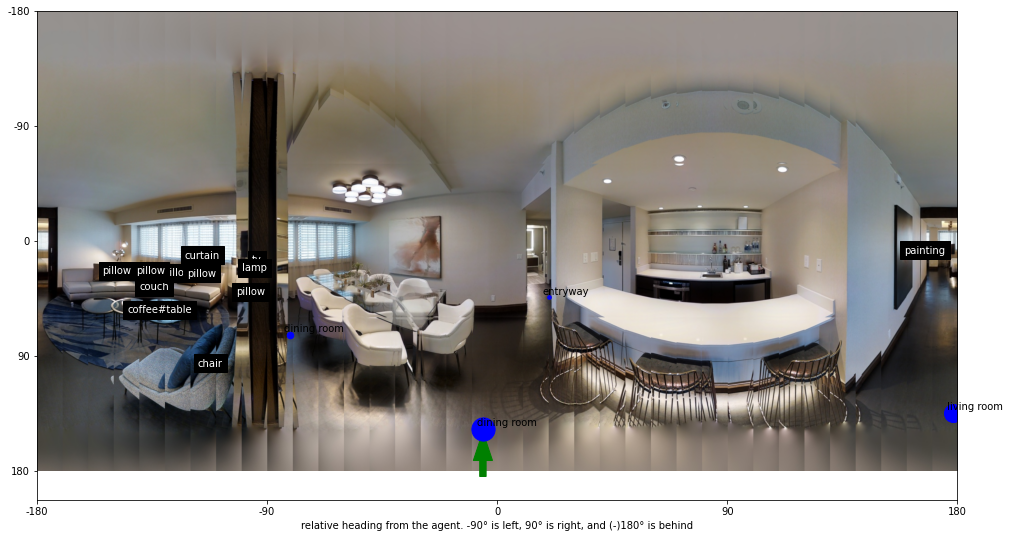

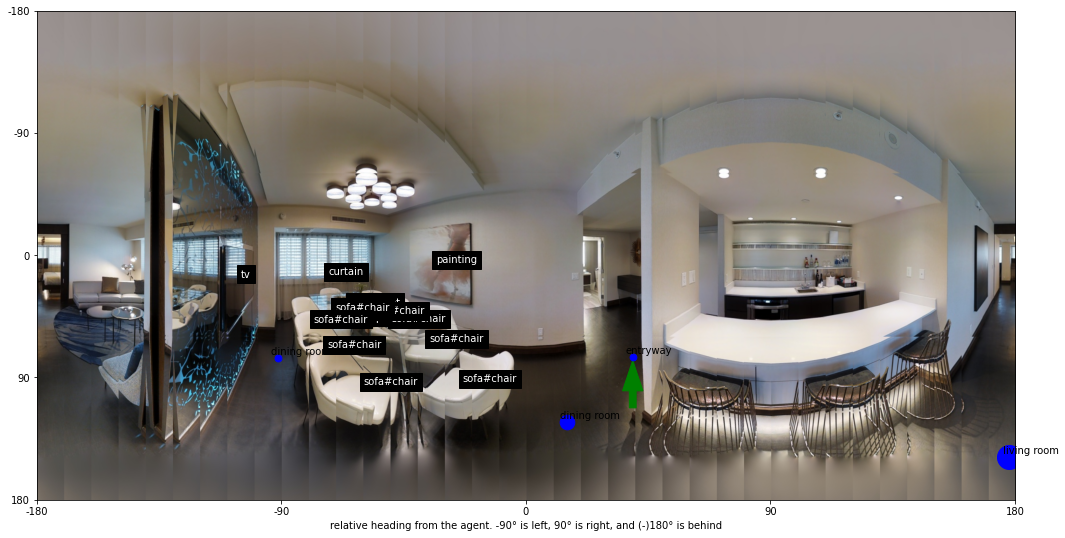

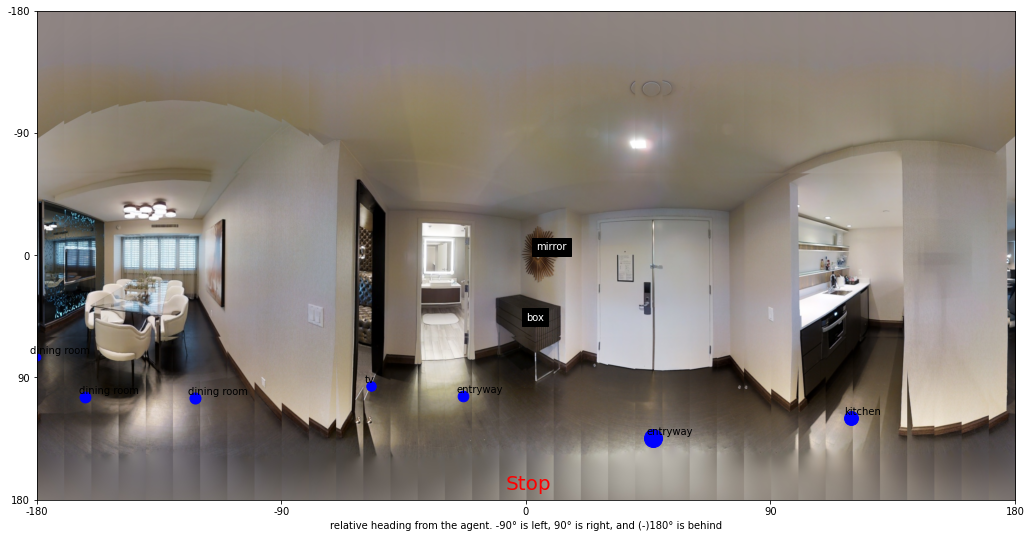

In [248]:
# Instructions
instructions = "- " + "\n\n- ".join(instruction_data['instructions'])
print(instructions)

heading = initial_heading
craft_instructions = ['']
used_objects = []
for idx, viewpoint in enumerate(viewpoints_sequence):
    if idx < len(viewpoints_sequence) - 1:
        new_short_craft_instruction, heading, used_object = get_info(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information, used_objects)
    else:
        new_short_craft_instruction, heading, used_object = get_info(scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information, used_objects)
        plt.text(2880 // 2 - 60, 1440 - 30, 'Stop', fontsize=20, color='r') # Stop
            
    if used_object:
        used_objects.append(used_object['name'])
    
    if new_short_craft_instruction and new_short_craft_instruction != craft_instructions[-1]:
        craft_instructions.append(new_short_craft_instruction)

craft_instruction = ". ".join([x for x in craft_instructions if x])

print(f"\n- {craft_instruction}")

In [247]:
instructions_path = f'/home/{IALAB_USER}/storage/are-you-looking/tasks/R2R-pano/data/R2R_objs_full_0_3_literal_speaker_data_augmentation_paths.json'

In [237]:
!pip install tqdm

Keyring is skipped due to an exception: org.freedesktop.DBus.Error.FileNotFound: Failed to connect to socket /run/user/1349/bus: No such file or directory
Defaulting to user installation because normal site-packages is not writeable


In [191]:
Out

{}

  0%|          | 0/178300 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

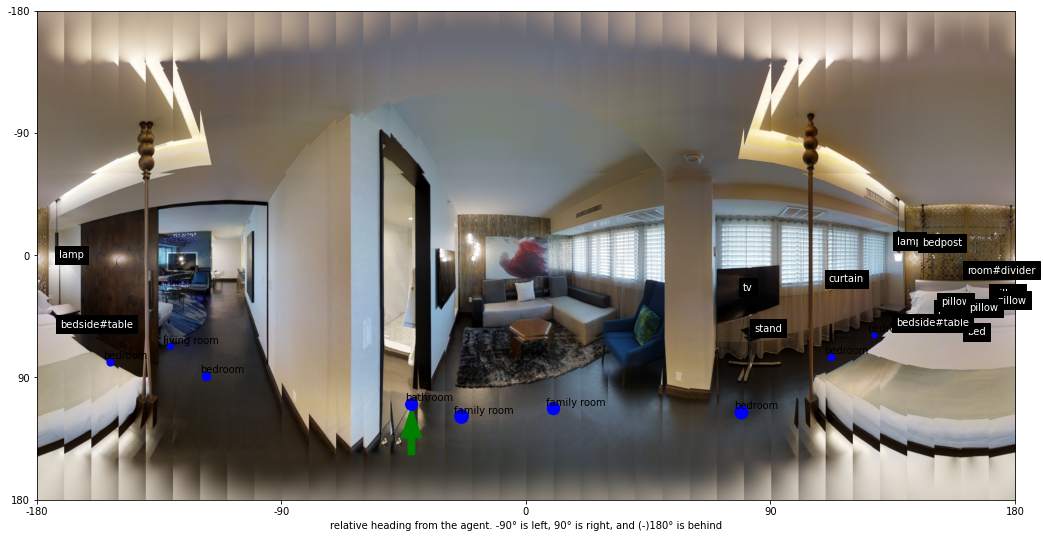

In [192]:
from tqdm.notebook import tqdm

with open(instructions_path, 'r') as f:
    data = json.load(f)

viewpoints_information = defaultdict(dict)
new_instructions_json = []
for i in tqdm(range(len(data))):    
    scan = data[i]['scan']
    viewpoints_sequence = data[i]['path']
    initial_heading = data[i]['heading']
    
    metadata = HouseSegmentationFile.load_mapping(scan, log=False)
    
    heading = initial_heading
    craft_instruction = ''
    for idx, viewpoint in enumerate(viewpoints_sequence):
        if idx < len(viewpoints_sequence) - 1:
            new_short_craft_instruction, heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information, False)
        else:
            new_short_craft_instruction, heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information, False)
        
        craft_instruction += f"{new_short_craft_instruction}. "
    
    instruction_data = data[i]
    new_instruction_data = instruction_data.copy()
    new_instruction_data['instructions'] = instruction_data['instructions'] + [craft_instruction]
    new_instructions_json.append(new_instruction_data)

In [ ]:
Out

In [ ]:
save_new_instructions_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/tasks/R2R/data/R2R_augmented_with_craft.json'

In [ ]:
#with open(save_new_instructions_path, 'w') as f:
#    data = json.dump(new_instructions_json, f)